# Computing window matrices with autodiff - sparse evaluation

In the other notebook ``isotropic.ipynb``, we estimated the window matrix with ``jax.javrev`` (or ``jax.jacfwd``) over multiple realizations of the field.

However, the memory footprint goes like the power estimation times the dimension of the input power spectrum. This is way to high in practical cases.
To mitigate that, we can take derivatives w.r.t. all input band powers one at a time (typically $\sim 1\;s$ on the GPU), but the computational cost blows up if we also have to average over $\mathcal{O}(100)$ realizations.

However, we can exploit the fact that the window matrix is almost diagonal.

In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jax import config
config.update('jax_enable_x64', True)

from jaxpower import (generate_gaussian_mesh, ParticleField, FKPField,
compute_mesh_power, compute_fkp_power, compute_normalization, PowerSpectrumMultipoles)

Let's implement a non-trivial survey selection function, e.g. $\bar{n}(x, y, z) \propto e^{-(x^2 + y^2 + z^2) / (0.2 L)}$, with $L = 2000 \, \mathrm{Mpc}/h$ the box size, truncated at the box boundaries.

In [2]:
def gaussian_survey(boxsize=2000., meshsize=128, boxcenter=0., size=int(1e6), seed=random.key(42), scale=0.1, paint=False):
    # Generate Gaussian-distributed positions
    positions = scale * boxsize * random.normal(seed, shape=(size, 3))
    toret = ParticleField(positions + boxcenter, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

def mock_survey(power, selection, offset=0., unitary_amplitude=False, seed=random.key(42), edges=None, **kwargs):
    # Generate Gaussian field
    mesh = generate_gaussian_mesh(lambda kvec: power(sum(kk**2 for kk in kvec)**0.5) + offset,
                                  boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                  unitary_amplitude=unitary_amplitude, seed=seed, **kwargs)
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    return compute_mesh_power(mesh * selection, edges=edges).clone(norm=norm)


In [3]:
from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
edges = np.arange(0., 0.2, 0.005)
edgesin = np.arange(0., 0.22, 0.001)
selection = gaussian_survey(size=int(1e7), paint=True)

kin = (edgesin[:-1] + edgesin[1:]) / 2.  # FIXME
pkin = pk(kin) * 4 * (1. + 0.2 * np.sin(kin / 0.006))

def get_pkin(pkin):

    def func(k):
        ibin = jnp.digitize(k, edgesin, right=False) - 1
        return jnp.where((ibin >= 0) & (ibin < len(pkin)), pkin[ibin], 0.)

    return func

get_pk = lambda pkin, **kwargs: mock_survey(get_pkin(pkin), selection, edges=edges, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacfwd(lambda pkin: get_pk(pkin, offset=1e-9, **kwargs).value[0].real)(pkin)
get_pk = jax.jit(get_pk)
get_wmat = jax.jit(get_wmat)

from tqdm import trange
pks, wmats, pkts = [], [], []
npk, npkt = 10, 10
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(pkin, seed=seed)
        wmats.append(wmat)
        pkts.append(wmat.dot(pkin))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


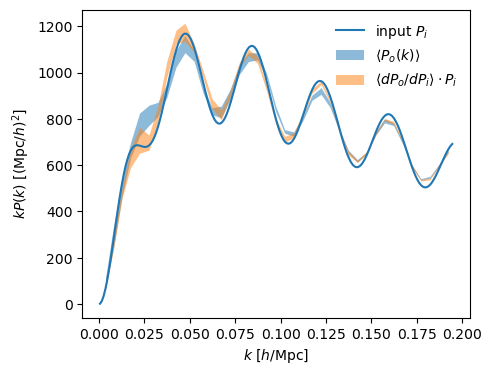

In [4]:
k, edges = pks[0].x(projs=0), pks[0].edges(projs=0)
pk_mean, pk_std = np.mean([pk.value[0].real for pk in pks], axis=0), np.std([pk.value[0].real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

In [5]:
vector = jnp.zeros_like(kin)
nshifts = 40
# Vector basis
# [[1, 0, 0, ..., 1, 0, 0, ...],
# [0, 1, 0, ..., 0, 1, 0, ...]]

basis = jnp.column_stack([vector.at[ishift::nshifts].set(1.) for ishift in range(nshifts)])

@jax.jit
def get_wmat_sparse(pkin, **kwargs):
    f = lambda pkin: get_pk(pkin, offset=1e-10, **kwargs).value[0].real
    _jvp = lambda s: jax.jvp(f, (pkin,), (s,))[1]
    jac = jax.vmap(_jvp, in_axes=1)(basis).T
    return jac

def reshape_wmat(jac):
    toret = np.zeros((len(k), len(kin)))
    for ivector, vector in enumerate(basis.T):
        inindices = np.flatnonzero(vector)
        kmid = (kin[inindices][:-1] + kin[inindices][1:]) / 2
        # Find closest ko's given ki's
        outindices = np.rint(np.interp(kmid, k, np.arange(len(k)))).astype(int)
        outindices = np.concatenate([[0], outindices, [len(k)]])
        #print(ivector, outindices)
        # We select in jac the ko ranges for the ki's
        outslices = [slice(start, stop) for start, stop in zip(outindices[:-1], outindices[1:])]
        for idx, sl in zip(inindices, outslices):
            toret[sl, idx] += jac[sl, ivector]
            #if idx < 30: print(jac[sl, ivector])
    return toret

In [6]:
wmats_sparse, pkts_sparse = [], []
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat_sparse(pkin, seed=seed)
        wmat = reshape_wmat(wmat)
        wmats_sparse.append(wmat)
        pkts_sparse.append(wmat.dot(pkin))

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


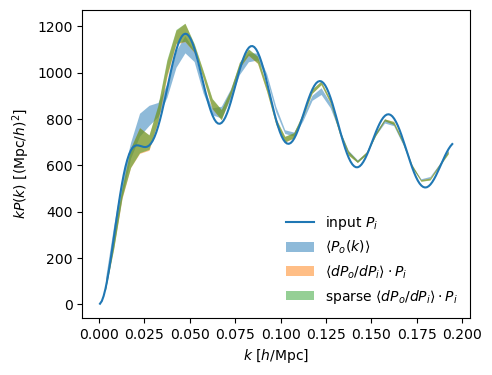

In [7]:
k, edges = pks[0].x(projs=0), pks[0].edges(projs=0)
pk_mean, pk_std = np.mean([pk.value[0].real for pk in pks], axis=0), np.std([pk.value[0].real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5
pkt_sparse_mean, pkt_sparse_std = np.mean(pkts_sparse, axis=0), np.std(pkts_sparse, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.fill_between(k, k * (pkt_sparse_mean - pkt_sparse_std), k * (pkt_sparse_mean + pkt_sparse_std), label=r'sparse $\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

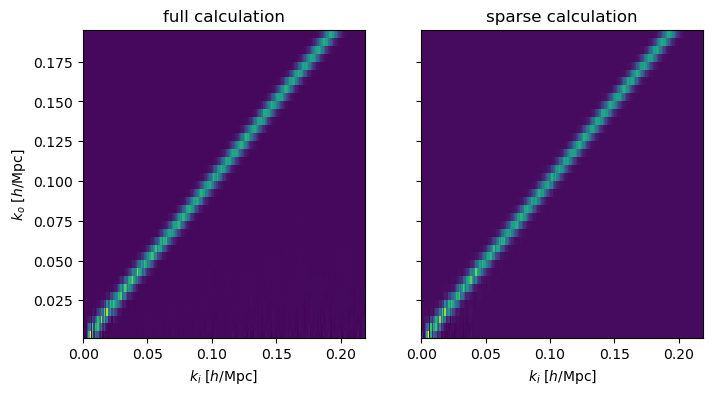

In [8]:
wmat = np.mean(wmats, axis=0)
wmat_sparse = np.mean(wmats_sparse, axis=0)
fig, lax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
lax[0].pcolormesh(kin, k, wmat)
lax[0].set_title('full calculation')
lax[1].pcolormesh(kin, k, wmat_sparse)
lax[1].set_title('sparse calculation')
lax[0].set_ylabel(r'$k_o$ [$h/\mathrm{Mpc}$]')
for ax in lax:
    ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
plt.show()

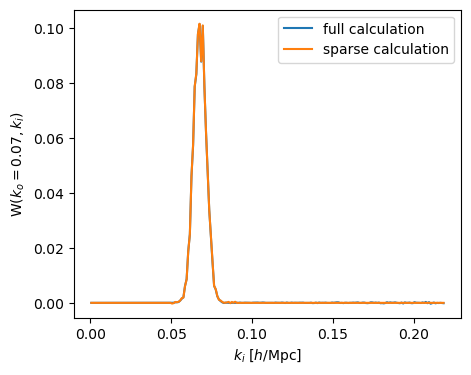

In [9]:
ax = plt.gca()
ax.plot(kin, wmat[np.argmin(np.abs(k - 0.07))], label='full calculation')
ax.plot(kin, wmat_sparse[np.argmin(np.abs(k - 0.07))], label='sparse calculation')
ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$\mathrm{W}(k_o=0.07, k_i)$')
ax.legend()
plt.show()